In [35]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
import re
import os
import math
import time
import statsmodels.api as sm

## ANOVA on Gaze

In [36]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(rc = {'figure.figsize':(15,8)})

In [37]:
def unix_to_datetime(ts):
    return datetime.utcfromtimestamp(ts)

def get_unique_days(df_column):
    realtime = df_column.apply(lambda x: unix_to_datetime(x))
    days = np.array(realtime.apply(lambda x: x.day))
    return days, np.unique(days)

def get_day_into_study(days, prev_days = 0):
    adj = list(range(0, len(days)))
    res = [x + prev_days for x in adj]
    return res

def search(l, n):
    for i in range(len(l)):
        if l[i] == n:
            return i
    return -1

def adjust_day(uniq, n, blind = 0):
    haystack = uniq[blind:]
    idx = search(haystack, n)
    return idx + blind

### Data Processing

In [38]:
# all participants
PIDS = [
    '1_EXP05/', '2_EXP01/', '3_EXP02/', 
    '4_EXP06/', '5_EXP07/', '6_EXP04/', '7_EXP03/', 
    '8_EXP11/', '9_EXP12/', '11_EXP13/',
    '12_EXP08/', '13_EXP15/', '14_EXP14/'
]

df_demographics = pd.read_csv('demographics.csv')

In [50]:
def getframes(file):
    frames_df = []
    
    for p in PIDS:
        print('processing', p)

        # read data
        df_c_w1 = pd.read_csv(p + 'week_1/' + file)
        df_c_w2 = pd.read_csv(p + 'week_2/' + file)
        df_c_w3 = pd.read_csv(p + 'week_3/' + file)
        df_c_w4 = pd.read_csv(p + 'week_4/' + file)

        # remove rows where the duration is 0
        df_c_w1 = df_c_w1[df_c_w1['duration'] != 0]
        df_c_w2 = df_c_w2[df_c_w2['duration'] != 0]
        df_c_w3 = df_c_w3[df_c_w3['duration'] != 0]
        df_c_w4 = df_c_w4[df_c_w4['duration'] != 0]

        # remove outliers
        # df_c_w1 = df_c_w1[(np.abs(stats.zscore(df_c_w1['duration'])) < 3)].reset_index()
        # df_c_w2 = df_c_w2[(np.abs(stats.zscore(df_c_w2['duration'])) < 3)].reset_index()
        # df_c_w3 = df_c_w3[(np.abs(stats.zscore(df_c_w3['duration'])) < 3)].reset_index()
        # df_c_w4 = df_c_w4[(np.abs(stats.zscore(df_c_w4['duration'])) < 3)].reset_index()

        # determine unique days in dataset
        _, unique_days_w1 = get_unique_days(df_c_w1['start'])
        _, unique_days_w2 = get_unique_days(df_c_w2['start'])
        _, unique_days_w3 = get_unique_days(df_c_w3['start'])
        _, unique_days_w4 = get_unique_days(df_c_w4['start'])

        unique_days = np.concatenate((unique_days_w1, unique_days_w2, unique_days_w3, unique_days_w4), axis = 0)

        # set day (of study) identifier
        df_c_w1['day'] = df_c_w1['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day))
        df_c_w2['day'] = df_c_w2['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)))
        df_c_w3['day'] = df_c_w3['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)+len(unique_days_w2)))
        df_c_w4['day'] = df_c_w4['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)+len(unique_days_w2)+len(unique_days_w3)))

        # set week identifier
        df_c_w1['week'] = 1
        df_c_w2['week'] = 2
        df_c_w3['week'] = 3
        df_c_w4['week'] = 4

        # apply data transform
        df_c_w1['log_duration'] = df_c_w1['duration'].apply(lambda x: math.log(x))
        df_c_w2['log_duration'] = df_c_w2['duration'].apply(lambda x: math.log(x))
        df_c_w3['log_duration'] = df_c_w3['duration'].apply(lambda x: math.log(x))
        df_c_w4['log_duration'] = df_c_w4['duration'].apply(lambda x: math.log(x))

        # combine all week dataframes
        frames = [df_c_w1, df_c_w2, df_c_w3, df_c_w4]
        df_c_p = pd.concat(frames)
        df_c_p['ID'] = p

        # get demographics
        pid = p.partition('_')[2][:-1]
        df_d = df_demographics[df_demographics['ID'].str.contains(pid)]
        for key, value in df_d.iteritems():
            if 'Date' in key:
                dt = datetime.strptime(df_d.iloc[0][key], '%M/%d/%Y').date()
                dt = time.mktime(dt.timetuple())
                df_c_p[key] = dt
            else:
                df_c_p[key] = df_d.iloc[0][key]
                
        # get aggregates
        e_total = df_c_p.shape[0]
        e_robot = df_c_p[df_c_p['object'] == 'robot'].shape[0]
        e_screen = df_c_p[df_c_p['object'] == 'screen'].shape[0]
        e_parent = df_c_p[df_c_p['object'] == 'parent'].shape[0]
        e_child = df_c_p[df_c_p['object'] == 'child'].shape[0]
        e_outside = df_c_p[df_c_p['object'] == 'outside'].shape[0]
        e_none = df_c_p[df_c_p['object'] == 'no detection'].shape[0]
        e_contact = df_c_p[df_c_p['object'] == 'contact'].shape[0]
        
        t_total = df_c_p['duration'].sum()
        t_robot = df_c_p[df_c_p['object'] == 'robot']['duration'].sum()
        t_screen = df_c_p[df_c_p['object'] == 'screen']['duration'].sum()
        t_parent = df_c_p[df_c_p['object'] == 'parent']['duration'].sum()
        t_child = df_c_p[df_c_p['object'] == 'child']['duration'].sum()
        t_outside = df_c_p[df_c_p['object'] == 'outside']['duration'].sum()
        t_none = df_c_p[df_c_p['object'] == 'no detection']['duration'].sum()
        t_contact = df_c_p[df_c_p['object'] == 'contact']['duration'].sum()
        
        print(e_total, e_robot, e_screen, e_parent, e_child, e_outside, e_none, e_contact)
        print(t_total, t_robot, t_screen, t_parent, t_child, t_outside, t_none, t_contact)

        # remove index
        # df_c_p = df_c_p[(np.abs(stats.zscore(df_c_p['log_duration'])) < 3)].reset_index() # remove overall outliers
        df_c_p = df_c_p.iloc[:, 1:]
        frames_df.append(df_c_p)

    df_c = pd.concat(frames_df, ignore_index=True)
    
    return df_c

In [51]:
df_c = getframes('child.csv')

processing 1_EXP05/
8821 797 3690 36 0 1816 0 0
1027696.8005506992 699.4158742427826 253271.70929789543 22.801477432250977 0.0 2767.1815977096558 0.0 0.0
processing 2_EXP01/
3098 599 989 417 0 604 0 0
7221.422483682632 470.24060106277466 3952.2525420188904 283.1908769607544 0.0 1272.3749222755432 0.0 0.0
processing 3_EXP02/
4207 617 1377 352 0 1177 0 0
888895.0555975437 86169.3948905468 786144.5552325249 342.5069029331207 0.0 1598.6738538742065 0.0 0.0
processing 4_EXP06/
5393 775 1894 141 0 1253 0 0
881821.4925465584 1646.7938885688782 267355.5080370903 83.90262937545776 0.0 86655.82283067703 0.0 0.0
processing 5_EXP07/
8790 1525 3480 229 0 1718 0 0
625702.6173901558 1204.2934193611145 451845.4950258731 122.70304346084595 0.0 2346.487676382065 0.0 0.0
processing 6_EXP04/
8790 1525 3480 229 0 1718 0 0
625702.6173901558 1204.2934193611145 451845.4950258731 122.70304346084595 0.0 2346.487676382065 0.0 0.0
processing 7_EXP03/
605 221 197 78 0 63 0 0
239117.98629546168 2580.000904083252 23

In [52]:
df_c

,object,duration,start,day,week,log_duration,ID,ADOS_Date,ADOS_SocialAffectTotalScore,ADOS_RRBTotalScore,...,DAS_Date,DAS_VerbalReasoningSS,DAS_NonVerbalReasoningSS,DAS_SpatialReasoningSS,DAS_GCASS,ADI_Date,ADI_Atotal,ADI_Btotal,ADI_Ctotal,ADI_Dtotal
0,nodetection,14.193398,1.499458e+09,0,1,2.652777,EXP05,1.451624e+09,8,4,...,1.422508e+09,51,71,66,55,1.422508e+09,26,16,8,4
1,outside,22.588879,1.499458e+09,0,1,3.117458,EXP05,1.451624e+09,8,4,...,1.422508e+09,51,71,66,55,1.422508e+09,26,16,8,4
2,nodetection,0.599435,1.499458e+09,0,1,-0.511768,EXP05,1.451624e+09,8,4,...,1.422508e+09,51,71,66,55,1.422508e+09,26,16,8,4
3,outside,0.099960,1.499458e+09,0,1,-2.302987,EXP05,1.451624e+09,8,4,...,1.422508e+09,51,71,66,55,1.422508e+09,26,16,8,4
4,nodetection,0.399282,1.499458e+09,0,1,-0.918088,EXP05,1.451624e+09,8,4,...,1.422508e+09,51,71,66,55,1.422508e+09,26,16,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81332,robot,2.799995,1.513114e+09,27,4,1.029618,EXP14,1.453266e+09,11,2,...,1.453352e+09,77,78,105,83,1.453352e+09,17,20,5,5
81333,screen,0.400006,1.513114e+09,27,4,-0.916276,EXP14,1.453266e+09,11,2,...,1.453352e+09,77,78,105,83,1.453352e+09,17,20,5,5
81334,robot,2.900211,1.513114e+09,27,4,1.064784,EXP14,1.453266e+09,11,2,...,1.453352e+09,77,78,105,83,1.453352e+09,17,20,5,5
81335,screen,1.400045,1.513114e+09,27,4,0.336504,EXP14,1.453266e+09,11,2,...,1.453352e+09,77,78,105,83,1.453352e+09,17,20,5,5


In [53]:
df_c = getframes('child.csv')
df_p = getframes('parent.csv')
df_r = getframes('robot.csv')
df_cp = getframes('child-parent.csv')
df_cr = getframes('child-robot.csv')
df_rp = getframes('parent-robot.csv')

processing 1_EXP05/
8821 797 3690 36 0 1816 0 0
1027696.8005506992 699.4158742427826 253271.70929789543 22.801477432250977 0.0 2767.1815977096558 0.0 0.0
processing 2_EXP01/
3098 599 989 417 0 604 0 0
7221.422483682632 470.24060106277466 3952.2525420188904 283.1908769607544 0.0 1272.3749222755432 0.0 0.0
processing 3_EXP02/
4207 617 1377 352 0 1177 0 0
888895.0555975437 86169.3948905468 786144.5552325249 342.5069029331207 0.0 1598.6738538742065 0.0 0.0
processing 4_EXP06/
5393 775 1894 141 0 1253 0 0
881821.4925465584 1646.7938885688782 267355.5080370903 83.90262937545776 0.0 86655.82283067703 0.0 0.0
processing 5_EXP07/
8790 1525 3480 229 0 1718 0 0
625702.6173901558 1204.2934193611145 451845.4950258731 122.70304346084595 0.0 2346.487676382065 0.0 0.0
processing 6_EXP04/
8790 1525 3480 229 0 1718 0 0
625702.6173901558 1204.2934193611145 451845.4950258731 122.70304346084595 0.0 2346.487676382065 0.0 0.0
processing 7_EXP03/
605 221 197 78 0 63 0 0
239117.98629546168 2580.000904083252 23

7936 0 261 89 0 0 0 7586
180183.2535173893 0.0 321.68798661231995 61.69916558265686 0.0 0.0 0.0 179799.86636519432
processing 7_EXP03/
583 0 86 0 0 0 0 497
302024.789516449 0.0 301267.9100308418 0.0 0.0 0.0 0.0 756.8794856071472
processing 8_EXP11/
6007 0 333 25 0 0 0 5649
270215.8559656143 0.0 509.73920035362244 16.3005108833313 0.0 0.0 0.0 269689.81625437737
processing 9_EXP12/
4454 0 174 5 0 0 0 4275
1076045.95621109 0.0 218.72978615760803 1.500866413116455 0.0 0.0 0.0 1075825.7255585194
processing 11_EXP13/
6331 0 337 22 0 0 0 5972
473670.8491871357 0.0 661.1144049167633 15.001283407211304 0.0 0.0 0.0 472994.7334988117
processing 12_EXP08/
4440 0 150 14 0 0 0 4276
271987.5431497097 0.0 268.3761417865753 10.799931287765503 0.0 0.0 0.0 271708.36707663536
processing 13_EXP15/
7936 0 261 89 0 0 0 7586
180183.2535173893 0.0 321.68798661231995 61.69916558265686 0.0 0.0 0.0 179799.86636519432
processing 14_EXP14/
7201 0 365 29 0 0 0 6807
1227423.4964380264 0.0 508.0764219760895 21.7016804

In [54]:
df_c.to_csv('child.csv')
df_p.to_csv('parent.csv')
df_r.to_csv('robot.csv')
df_cp.to_csv('child-parent.csv')
df_cr.to_csv('child-robot.csv')
df_rp.to_csv('parent-robot.csv')

In [57]:
pids = df_c['ID'].unique()
for pid in pids:
    df_i = df_c[df_c['ID'] == pid]
    total_events = df_i.shape[0]
    robot_events = df_i[df_i['object'] == 'robot'].shape[0]
    print(pid, total_events, robot_events)

EXP05 8821 797
EXP01 3098 599
EXP02 4207 617
EXP06 5393 775
EXP07 8790 1525
EXP04 8790 1525
EXP03 605 221
EXP11 7514 862
EXP12 5812 503
EXP13 7069 1254
EXP08 5027 471
EXP15 8184 1615
EXP14 8027 1126


### Plots

In [20]:
# which object are we looking at?
obj = 'robot'

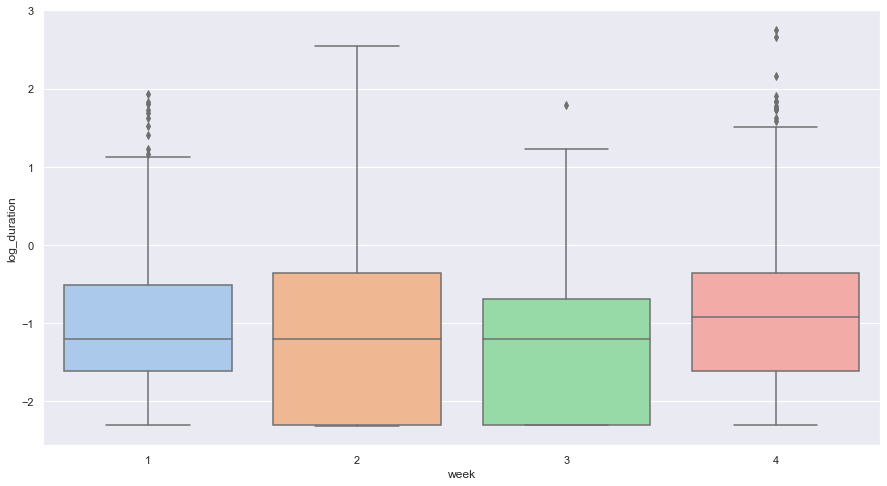

In [44]:
# example weekly analysis, entire study
ax = sns.boxplot(x="week", y="log_duration", data=df_c[df_c["object"] == "parent"], palette="pastel")

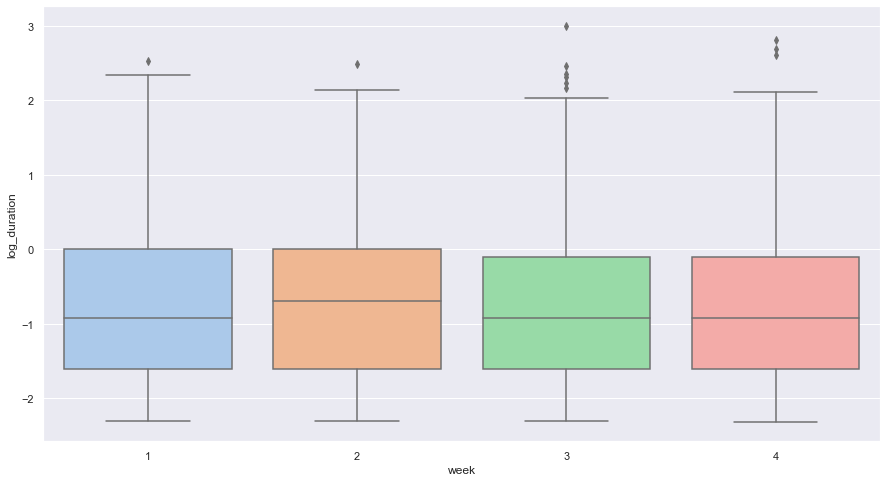

In [45]:
ax = sns.boxplot(x="week", y="log_duration", data=df_c[df_c["object"] == 'robot'], palette="pastel")

### One-Way ANOVA

In [41]:
df_c_summary = pd.DataFrame({
    'Week 1': df_c[(df_c['week'] == 1) & (df_c['object'] == "parent")]['log_duration'], # df_c_w1[df_c_w1['object'] == obj]['duration'], 
    'Week 2': df_c[(df_c['week'] == 2) & (df_c['object'] == "parent")]['log_duration'], # df_c_w2[df_c_w2['object'] == obj]['duration'], 
    'Week 3': df_c[(df_c['week'] == 3) & (df_c['object'] == "parent")]['log_duration'], # df_c_w3[df_c_w3['object'] == obj]['duration'], 
    'Week 4': df_c[(df_c['week'] == 4) & (df_c['object'] == "parent")]['log_duration']  # df_c_w4[df_c_w4['object'] == obj]['duration']
})

In [42]:
df_c_summary.describe()

,Week 1,Week 2,Week 3,Week 4
count,240.000000,1236.000000,629.000000,902.000000
mean,-1.020324,-1.122603,-1.281651,-1.015491
std,1.039154,1.013812,0.921667,0.994276
min,-2.306671,-2.309630,-2.307531,-2.305762
25%,-1.609719,-2.297736,-2.300826,-1.610448
50%,-1.204291,-1.204076,-1.205846,-0.916437
75%,-0.510804,-0.356507,-0.693233,-0.356685
max,1.931546,2.541582,1.791764,2.747285


In [43]:
# one-way ANOVA, check if model is significant
F, p = stats.f_oneway(
    df_c[(df_c['week'] == 1) & (df_c['object'] == "parent")]['log_duration'],
    df_c[(df_c['week'] == 2) & (df_c['object'] == "parent")]['log_duration'],
    df_c[(df_c['week'] == 3) & (df_c['object'] == "parent")]['log_duration'],
    df_c[(df_c['week'] == 4) & (df_c['object'] == "parent")]['log_duration']
)

print('F-Statistic=%.3f, p=%.3f' % (F, p))

# if we see that p-value is < 0.05. 
# we can reject the null hypothesis which states that there is no difference among the different density groups

F-Statistic=9.707, p=0.000


In [21]:
# if the distribution is not normal, use the non-parametric version of ANOVA
# the kurskal-wallis H-test

stats.kruskal(
    df_c[(df_c['week'] == 1) & (df_c['object'] == obj)]['log_duration'], 
    df_c[(df_c['week'] == 2) & (df_c['object'] == obj)]['log_duration'],
    df_c[(df_c['week'] == 3) & (df_c['object'] == obj)]['log_duration'],
    df_c[(df_c['week'] == 4) & (df_c['object'] == obj)]['log_duration']
)

KruskalResult(statistic=38.324422107580304, pvalue=2.4129808957518783e-08)

In [26]:
from statsmodels.formula.api import ols

# one-way ANOVA, regress against each input variable to check influence over the target variable
model = ols('log_duration ~ C(week)', df_c[df_c['object'] == 'child']).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_duration   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.342
Date:                Fri, 25 Mar 2022   Prob (F-statistic):             0.0184
Time:                        10:56:17   Log-Likelihood:                -24048.
No. Observations:               15731   AIC:                         4.810e+04
Df Residuals:                   15727   BIC:                         4.813e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.7667      0.020    -38.239      0.000      -0.806      -0.727
C(week)[T.2]    -0.0681      0.025     -2.749      0.006      -0.117      -0.020
C(week)[T.3]    -0.0089      0.029     -0.303      0.762      -0.066       0.049
C(week)[T.4]    -0.0482      0.027     -1.805      0.071      -0.100       0.004
==============================================================================
Omnibus:                      700.812   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              587.679
Skew:                           0.400   Prob(JB):                    2.44e-128
Kurtosis:                       2.494   Cond. No.                         5.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
# testing effects of the demographics
y = df_c['log_duration']
x_dummies = pd.get_dummies(df_c['object'], drop_first=False)
x = df_c.drop(['log_duration', 'duration', 'ID', 'object', 'initiator', 'lag'], axis = 1)
x = pd.concat((x_dummies, x), axis = 1)

In [13]:
x

,child,contact,screen,start,initiator,lag,day,week,ADOS_Date,ADOS_SocialAffectTotalScore,...,DAS_Date,DAS_VerbalReasoningSS,DAS_NonVerbalReasoningSS,DAS_SpatialReasoningSS,DAS_GCASS,ADI_Date,ADI_Atotal,ADI_Btotal,ADI_Ctotal,ADI_Dtotal
0,1,0,0,1.499712e+09,robot,253581.136358,0,1,1.451624e+09,8,...,1.422508e+09,51,71,66,55,1.422508e+09,26,16,8,4
1,1,0,0,1.499712e+09,robot,253583.136358,0,1,1.451624e+09,8,...,1.422508e+09,51,71,66,55,1.422508e+09,26,16,8,4
2,1,0,0,1.499712e+09,robot,253583.136358,0,1,1.451624e+09,8,...,1.422508e+09,51,71,66,55,1.422508e+09,26,16,8,4
3,1,0,0,1.499712e+09,robot,253584.136358,0,1,1.451624e+09,8,...,1.422508e+09,51,71,66,55,1.422508e+09,26,16,8,4
4,1,0,0,1.499712e+09,robot,253589.136358,0,1,1.451624e+09,8,...,1.422508e+09,51,71,66,55,1.422508e+09,26,16,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21530,1,0,0,1.506383e+09,robot,39.450186,13,4,1.453266e+09,11,...,1.453352e+09,77,78,105,83,1.453352e+09,17,20,5,5
21531,1,0,0,1.506383e+09,robot,44.450186,13,4,1.453266e+09,11,...,1.453352e+09,77,78,105,83,1.453352e+09,17,20,5,5
21532,1,0,0,1.506383e+09,robot,49.450186,13,4,1.453266e+09,11,...,1.453352e+09,77,78,105,83,1.453352e+09,17,20,5,5
21533,1,0,0,1.506383e+09,robot,50.450186,13,4,1.453266e+09,11,...,1.453352e+09,77,78,105,83,1.453352e+09,17,20,5,5


In [18]:
# run if demographics are already in the dataframe
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           log_duration   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     21.06
Date:                Fri, 25 Mar 2022   Prob (F-statistic):           3.94e-65
Time:                        10:41:06   Log-Likelihood:                -32945.
No. Observations:               21535   AIC:                         6.593e+04
Df Residuals:                   21517   BIC:                         6.607e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [477]:
# check if overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")

Overall model F( 3, 73193) =  70.693, p =  0.0000


In [458]:
# create the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

# from the output, we see that the p  >0.05. 
# Therefore, we cannot reject the null hypothesis. 
# There is no difference among the different weeks

,sum_sq,df,F,PR(>F)
C(week),85.433022,3.0,20.158223,5.043648e-13
Residual,15490.338222,10965.0,NaN,NaN


### Post Hoc

In [19]:
import statsmodels.stats.multicomp

# tukey hsd test to examine where the group differences lie
mc = statsmodels.stats.multicomp.MultiComparison(
    df_c['log_duration'], 
    df_c['week'])
mc_results = mc.tukeyhsd()
print(mc_results)

# where reject = True, there is a significant difference between the groups

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2  -0.0056    0.9 -0.0575  0.0463  False
     1      3   0.0699 0.0223   0.007  0.1328   True
     1      4  -0.0188  0.816 -0.0767  0.0391  False
     2      3   0.0755 0.0046  0.0175  0.1336   True
     2      4  -0.0132    0.9 -0.0658  0.0394  False
     3      4  -0.0887 0.0019 -0.1522 -0.0253   True
----------------------------------------------------


In [460]:
# normality assumption check using shapiro wilk test
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

# if the p-value >0.05
# we can conclude that our data follows the gaussian distribution
# else, it doesn't follow the assumptions of the ANOVA model

0.9603163599967957 0.0


c:\users\rramn\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning:

p-value may not be accurate for N > 5000.



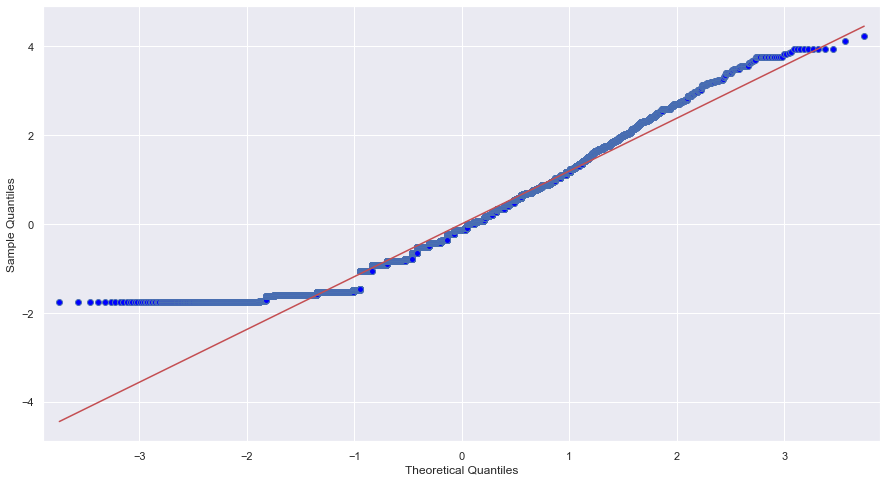

In [461]:
# using the Normal Q-Q plot to test this assumption
res = model.resid
fig = sm.qqplot(res, line='s')
plt.show()

# if we see that all data points lie close to the 45-degree line
# we can conclude it follows the normal distribution

In [570]:
# homogeneity of variance assumption check

# Bartlett variance test, Method 1
wb, pb = stats.bartlett(
    df_c[(df_c['week'] == 1) & (df_c['object'] == obj)]['log_duration'], 
    df_c[(df_c['week'] == 2) & (df_c['object'] == obj)]['log_duration'], 
    df_c[(df_c['week'] == 3) & (df_c['object'] == obj)]['log_duration'], 
    df_c[(df_c['week'] == 4) & (df_c['object'] == obj)]['log_duration']
)
print('Bartlett variance test: w=%.3f, p=%.3f' % (wb, pb))

# Levene variance test, Method 2
wl, pl = stats.levene(
    df_c[(df_c['week'] == 1) & (df_c['object'] == obj)]['log_duration'], 
    df_c[(df_c['week'] == 2) & (df_c['object'] == obj)]['log_duration'], 
    df_c[(df_c['week'] == 3) & (df_c['object'] == obj)]['log_duration'], 
    df_c[(df_c['week'] == 4) & (df_c['object'] == obj)]['log_duration']
)
print('Levene variance test: w=%.3f, p=%.3f' % (wl, pl))

# if we see p > 0.05 for all weeks
# we can conclude that groups have equal variances

Bartlett variance test: w=30.346, p=0.000
Levene variance test: w=10.900, p=0.000


### Two-Way ANOVA

In [593]:
model2 = ols('log_duration ~ C(object)', df_c).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_duration   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     534.3
Date:                Wed, 23 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:47:46   Log-Likelihood:                -48686.
No. Observations:               31562   AIC:                         9.738e+04
Df Residuals:                   31557   BIC:                         9.742e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.9102      0.018    -51.880      0.000      -0.945      -0.876
C(object)[T.nodetection]     0.2248      0.021     10.618      0.000       0.183       0.266
C(object)[T.outside]        -0.0504      0.033     -1.514      0.130      -0.116       0.015
C(object)[T.robot]          -0.0731      0.031     -2.325      0.020      -0.135      -0.011
C(object)[T.screen]          0.6690      0.020     33.691      0.000       0.630       0.708
==============================================================================
Omnibus:                     1288.307   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              591.213
Skew:                           0.104   Prob(JB):                    4.17e-129
Kurtosis:                       2.362   Cond. No.                         8.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [573]:
print(f"Overall model F({model2.df_model: },{model2.df_resid: }) = {model2.fvalue: }, p = {model2.f_pvalue: }")

Overall model F( 2.0, 89165.0) =  44.030377202003876, p =  7.714123727865993e-20


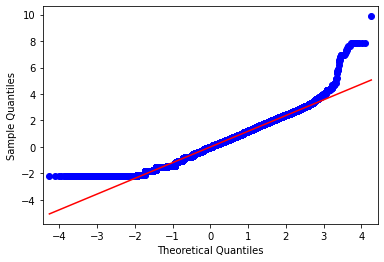

In [73]:
# create the ANOVA table
res2 = sm.stats.anova_lm(model2, typ=2)
res2

# check the Normal distribution of residuals
res = model2.resid
fig = sm.qqplot(res, line='s')
plt.show()

# from the Q-Q plot, we can see that residuals are almost normally distributed
# (although points at the extreme ends can be discounted)
# hence we conclude that it satisfies the normality assumption of the ANOVA test

In [575]:
# check the interaction of groups
formula = 'log_duration ~ C(week) *C(object)'
model = ols(formula, df_c).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_duration   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     13.64
Date:                Wed, 23 Mar 2022   Prob (F-statistic):           1.55e-26
Time:                        14:20:47   Log-Likelihood:            -1.4308e+05
No. Observations:               89168   AIC:                         2.862e+05
Df Residuals:                   89156   BIC:                         2.863e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -0.5363      0.013    -42.489      0.000      -0.561      -0.512
C(week)[T.2]                         0.0505      0.014      3.521      0.000       0.022       0.079
C(week)[T.3]                        -0.0043      0.015     -0.277      0.782      -0.034       0.026
C(week)[T.4]                         0.0425      0.015      2.892      0.004       0.014       0.071
C(object)[T.parent]                  0.2745      0.143      1.914      0.056      -0.007       0.556
C(object)[T.screen]                  0.0974      0.048      2.042      0.041       0.004       0.191
C(week)[T.2]:C(object)[T.parent]    -0.6380      0.154     -4.137      0.000      -0.940      -0.336
C(week)[T.3]:C(object)[T.parent]    -0.6551      0.167     -3.914      0.000      -0.983      -0.327
C(week)[T.4]:C(object)[T.parent]    -0.8530      0.172     -4.955      0.000      -1.190      -0.516
C(week)[T.2]:C(object)[T.screen]    -0.0649      0.058     -1.115      0.265      -0.179       0.049
C(week)[T.3]:C(object)[T.screen]     0.1282      0.073      1.767      0.077      -0.014       0.270
C(week)[T.4]:C(object)[T.screen]    -0.0751      0.062     -1.203      0.229      -0.198       0.047
==============================================================================
Omnibus:                     3061.053   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2167.568
Skew:                           0.277   Prob(JB):                         0.00
Kurtosis:                       2.475   Cond. No.                         83.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [487]:
from statsmodels.stats.anova import anova_lm
aov_table = anova_lm(model, typ=2)
print(aov_table.round(4))

                        sum_sq        df          F  PR(>F)
C(week)                88.5195       3.0    21.7115     0.0
C(object)            9898.5591       4.0  1820.8941     0.0
C(week):C(object)     490.9915      12.0    30.1069     0.0
Residual           136372.6764  100346.0        NaN     NaN


In [527]:
df_c_summary = pd.DataFrame({
    'Robot': df_c[df_c['object'] == 'robot']['duration'],
    'Child': df_c[df_c['object'] == 'child']['duration'], 
    'Screen': df_c[df_c['object'] == 'screen']['duration'],
    'Outside': df_c[df_c['object'] == 'outside']['duration']
})
df_c_summary.describe()

,Robot,Child,Screen,Outside
count,10969.000000,8207.000000,23514.000000,7462.000000
mean,1.146463,0.783111,2.218578,1.507798
std,2.320793,1.322729,3.945293,3.357934
min,0.099299,0.099124,0.099254,0.099361
25%,0.200021,0.199945,0.299910,0.199982
50%,0.400170,0.400037,0.799667,0.400159
75%,1.000559,0.899565,2.299962,1.199991
max,34.800070,25.799165,52.500093,34.298925


In [532]:
mc = statsmodels.stats.multicomp.MultiComparison(df_c[df_c['object'] != 'nodetection']['log_duration'], df_c[df_c['object'] != 'nodetection']['object'])
mc_results = mc.tukeyhsd()
print(mc_results)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
  child outside   0.2163  0.001  0.1628  0.2698   True
  child   robot   0.1634  0.001  0.1145  0.2122   True
  child  screen   0.6704  0.001  0.6275  0.7133   True
outside   robot  -0.0529 0.0342 -0.1031 -0.0027   True
outside  screen   0.4541  0.001  0.4097  0.4986   True
  robot  screen    0.507  0.001  0.4684  0.5457   True
------------------------------------------------------


## ANOVA on Joint Attention

In [3]:
from scipy import stats
import statsmodels.api as sm

In [4]:
PID = '1_EXP05_Full/'

In [5]:
# read from existing files
df_cr_w1 = pd.read_csv(PID + 'week_1/' + 'child-robot.csv')
df_cp_w1 = pd.read_csv(PID + 'week_1/' + 'child-parent.csv')
df_pr_w1 = pd.read_csv(PID + 'week_1/' + 'parent-robot.csv')

df_cr_w2 = pd.read_csv(PID + 'week_2/' + 'child-robot.csv')
df_cp_w2 = pd.read_csv(PID + 'week_2/' + 'child-parent.csv')
df_pr_w2 = pd.read_csv(PID + 'week_2/' + 'parent-robot.csv')

df_cr_w3 = pd.read_csv(PID + 'week_3/' + 'child-robot.csv')
df_cp_w3 = pd.read_csv(PID + 'week_3/' + 'child-parent.csv')
df_pr_w3 = pd.read_csv(PID + 'week_3/' + 'parent-robot.csv')

df_cr_w4 = pd.read_csv(PID + 'week_4/' + 'child-robot.csv')
df_cp_w4 = pd.read_csv(PID + 'week_4/' + 'child-parent.csv')
df_pr_w4 = pd.read_csv(PID + 'week_4/' + 'parent-robot.csv')

In [6]:
# remove outlier lags based on stable behavior throughout the week
df_cr_w1 = df_cr_w1[(np.abs(stats.zscore(df_cr_w1['lag'])) < 3)].reset_index()
df_cp_w1 = df_cp_w1[(np.abs(stats.zscore(df_cp_w1['lag'])) < 3)].reset_index()
df_pr_w1 = df_pr_w1[(np.abs(stats.zscore(df_pr_w1['lag'])) < 3)].reset_index()

df_cr_w2 = df_cr_w2[(np.abs(stats.zscore(df_cr_w2['lag'])) < 3)].reset_index()
df_cp_w2 = df_cp_w2[(np.abs(stats.zscore(df_cp_w2['lag'])) < 3)].reset_index()
df_pr_w2 = df_pr_w2[(np.abs(stats.zscore(df_pr_w2['lag'])) < 3)].reset_index()

df_cr_w3 = df_cr_w3[(np.abs(stats.zscore(df_cr_w3['lag'])) < 3)].reset_index()
df_cp_w3 = df_cp_w3[(np.abs(stats.zscore(df_cp_w3['lag'])) < 3)].reset_index()
df_pr_w3 = df_pr_w3[(np.abs(stats.zscore(df_pr_w3['lag'])) < 3)].reset_index()

df_cr_w4 = df_cr_w4[(np.abs(stats.zscore(df_cr_w4['lag'])) < 3)].reset_index()
df_cp_w4 = df_cp_w4[(np.abs(stats.zscore(df_cp_w4['lag'])) < 3)].reset_index()
df_pr_w4 = df_pr_w4[(np.abs(stats.zscore(df_pr_w4['lag'])) < 3)].reset_index()

In [5]:
def unix_to_datetime(ts):
    return datetime.utcfromtimestamp(ts)

def get_unique_days(df_column):
    realtime = df_column.apply(lambda x: unix_to_datetime(x))
    days = np.array(realtime.apply(lambda x: x.day))
    return days, np.unique(days)

def get_day_into_study(days, prev_days = 0):
    adj = list(range(0, len(days)))
    res = [x + prev_days for x in adj]
    return res

def search(l, n):
    for i in range(len(l)):
        if l[i] == n:
            return i
    return -1

def adjust_day(uniq, n, blind = 0):
    haystack = uniq[blind:]
    idx = search(haystack, n)
    return idx + blind

In [8]:
_, unique_days_w1 = get_unique_days(df_cr_w1['start'])
_, unique_days_w2 = get_unique_days(df_cr_w2['start'])
_, unique_days_w3 = get_unique_days(df_cr_w3['start'])
_, unique_days_w4 = get_unique_days(df_cr_w4['start'])

unique_days = np.concatenate((unique_days_w1, unique_days_w2, unique_days_w3, unique_days_w4), axis = 0)
print(unique_days)

[ 7 10 11 14 16 17 18 20 21 22 23 25 27 28  2  3  4  5  6  7  8 29 30 31]


In [9]:
df_cr_w1['day_study'] = df_cr_w1['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day))
df_cr_w2['day_study'] = df_cr_w2['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)))
df_cr_w3['day_study'] = df_cr_w3['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)+len(unique_days_w2)))
df_cr_w4['day_study'] = df_cr_w4['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)+len(unique_days_w2)+len(unique_days_w3)))

In [93]:
# frames = [df_cr_w1, df_cr_w2, df_cr_w3, df_cr_w4]
# df_cr = pd.concat(frames)
# df_cr = df_cr.iloc[:, 1:]

In [94]:
df_cr

,object,duration,start,initiator,lag,day_study,week_study
0,contact,0.999396,1.499458e+09,robot,13.697562,0,1
1,contact,19.099964,1.499458e+09,robot,14.796889,0,1
2,contact,1.499971,1.499458e+09,robot,0.904794,0,1
3,contact,2.199933,1.499458e+09,robot,2.504795,0,1
4,contact,0.199958,1.499458e+09,robot,4.804777,0,1
...,...,...,...,...,...,...,...
6358,contact,0.000000,1.502151e+09,robot,10.845541,20,4
6359,contact,0.199831,1.502151e+09,robot,10.945595,20,4
6360,contact,0.200178,1.502151e+09,robot,11.245524,20,4
6361,contact,4.099981,1.502151e+09,robot,11.545519,20,4


In [ ]:
model = sm.OLS(resumption_lag_y, resumption_lag_x)
results = model.fit()
print(results.summary())

In [ ]:
# across control and experimental
resumption_lag_y = df_x['te_p_resumption'] - df_x['a_p_resumption']
resumption_lag_x = df_x.drop(columns=['te_p_resumption', 'a_p_resumption'])